In [10]:
# Importing necessary libraries
from pythtb import *
import matplotlib.pyplot as plt 

# Initializing the Wannier90 model by reading the data files
pgda=w90(r"/home/alwin/Desktop/Long EXP/long_Aprilexp2025/PdGa_Hamiltonian/PdGa_Ham1",r"wannier90")
my_model=pgda.model(min_hopping_norm=0.01) # only hoppings with norm greater than 0.01 are considered

In [2]:
# To write the band velocity operator at a k-point
def calculate_v_euler_forward(k_vec, dk=0.01):
    H = my_model._gen_ham([k_vec[0], k_vec[1], k_vec[2]])
    Hx = my_model._gen_ham([k_vec[0]+dk, k_vec[1], k_vec[2]])
    Hy = my_model._gen_ham([k_vec[0], k_vec[1]+dk, k_vec[2]])
    Hz = my_model._gen_ham([k_vec[0], k_vec[1], k_vec[2]+dk])

    vx = (Hx-H)/dk
    vy = (Hy-H)/dk
    vz = (Hz-H)/dk
    return np.array((vx, vy, vz))

In [3]:
# method 2 .............

# defining Lx,Ly and lz operators for Pd and ga atoms
import numpy as np
import math
# angular momentum for Ga ( p-obital)
Lz_Ga = [[0,0,0],[0,0,-1j],[0,1j,0]]
Lx_Ga = [[0,0,1j],[0,0,0],[-1j,0,0]]
Ly_Ga = [[0,-1j,0],[1j,0,0],[0,0,0]]

# angular momentum for Pd ( d-obital)
Lz_Pd = [[0,0,0,0,0],[0,0,-1j,0,0],[0,1j,0,0,0],[0,0,0,0,-2j],[0,0,0,2j,0]]
Ly_Pd = [[0,-1j*math.sqrt(3),0,0,0],[1j*math.sqrt(3),0,0,1j,0],[0,0,0,0,-1j],[0,-1j,0,0,0],[0,0,1j,0,0]]
Lx_Pd = [[0,0,1j*math.sqrt(3),0,0],[0,0,0,0,-1j],[-1j*math.sqrt(3),0,0,1j,0],[0,0,-1j,0,0],[0,1j,0,0,0]]

In [4]:
def L_matrix(L_Ga, L_Pd, choice_of_xyz):

    if choice_of_xyz == 'x':

        Lx_Pd = np.tile(L_Pd[0], (4, 4))  # Duplicate the Lz_Pd matrix 4 times
        Lx_Ga = np.tile(L_Ga[0], (4, 4))  # Duplicate the Lz_Ga matrix 4 times
        
        Lx = np.zeros((32, 32), dtype=complex)
        Lx[0:20, 0:20] = Lx_Pd
        Lx[20:32, 20:32] = Lx_Ga
        Lx = np.kron(np.eye(2), Lx)

        return np.imag(Lx)
    
    elif choice_of_xyz == 'y':
        Ly_Pd = np.tile(L_Pd[1], (4, 4))  # Duplicate the Lz_Pd matrix 4 times
        Ly_Ga = np.tile(L_Ga[1], (4, 4))  # Duplicate the Lz_Ga matrix 4 times
        
        Ly = np.zeros((32, 32), dtype=complex)
        Ly[0:20, 0:20] = Ly_Pd
        Ly[20:32, 20:32] = Ly_Ga
        Ly = np.kron(np.eye(2), Ly)

        return np.imag(Ly)
    elif choice_of_xyz == 'z':
        Lz_Pd = np.tile(L_Pd[2], (4, 4))  # Duplicate the Lz_Pd matrix 4 times
        Lz_Ga = np.tile(L_Ga[2], (4, 4))  # Duplicate the Lz_Ga matrix 4 times
        
        Lz = np.zeros((32, 32), dtype=complex)
        Lz[0:20, 0:20] = Lz_Pd
        Lz[20:32, 20:32] = Lz_Ga
        Lz = np.kron(np.eye(2), Lz)

        return np.imag(Lz) 
    else :     # for all 
        Lx_Pd = np.tile(L_Pd[0], (4, 4))  # Duplicate the Lz_Pd matrix 4 times
        Lx_Ga = np.tile(L_Ga[0], (4, 4))  # Duplicate the Lz_Ga matrix 4 times
        
        Lx = np.zeros((32, 32), dtype=complex)
        Lx[0:20, 0:20] = Lx_Pd
        Lx[20:32, 20:32] = Lx_Ga
        Lx = np.kron(np.eye(2), Lx)

        Ly_Pd = np.tile(L_Pd[1], (4, 4))  # Duplicate the Lz_Pd matrix 4 times
        Ly_Ga = np.tile(L_Ga[1], (4, 4))  # Duplicate the Lz_Ga matrix 4 times
        
        Ly = np.zeros((32, 32), dtype=complex)
        Ly[0:20, 0:20] = Ly_Pd
        Ly[20:32, 20:32] = Ly_Ga
        Ly = np.kron(np.eye(2), Ly)

        Lz_Pd = np.tile(L_Pd[2], (4, 4))  # Duplicate the Lz_Pd matrix 4 times
        Lz_Ga = np.tile(L_Ga[2], (4, 4))  # Duplicate the Lz_Ga matrix 4 times
        
        Lz = np.zeros((32, 32), dtype=complex)
        Lz[0:20, 0:20] = Lz_Pd
        Lz[20:32, 20:32] = Lz_Ga
        Lz = np.kron(np.eye(2), Lz)
        
        return [Lx,Ly,Lz]

In [5]:
L_Ga = [Lx_Ga, Ly_Ga, Lz_Ga ]
L_Pd = [Lx_Pd, Ly_Pd, Lz_Pd ]
choice_of_xyz = ''
result = L_matrix(L_Ga, L_Pd, '')

In [6]:
def solve_and_calculate_Omega_xyz_method2(k_vec, eta=0.01):
    v = calculate_v_euler_forward(k_vec)
    eig_values, eig_vectors = my_model.solve_one(k_vec, eig_vectors=True)
    Lz = L_matrix(L_Ga, L_Pd, 'z')

    Omega_xyz = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m == n:
                continue
            val1 = np.vdot(eig_vectors[n], v[0] @ eig_vectors[m])
            val2 = np.vdot(eig_vectors[m], v[1] @ eig_vectors[n])
            Lz_n = np.vdot(eig_vectors[n], Lz @ eig_vectors[n])  # scalar
            Lz_m = np.vdot(eig_vectors[m], Lz @ eig_vectors[m])  # scalar
            temp -= (Lz_n + Lz_m) * val1 * val2 / (eig_values[n] - eig_values[m] + complex(0, eta))**2
        Omega_xyz[n] = np.imag(temp / 2)
    return eig_values, Omega_xyz


In [7]:
# method 2 ..........

# Choosing the path
path=[[0.0,0.0, 0.0],[0.5,0.0, 0.0],[0.5,0.5,0.0],[0.0,0.0, 0.0],[0.5,0.5,0.5],[0.5,0.0, 0.0]]
k_label=(r'$\Gamma$', r'$X$', r'$M$', r'$\Gamma$', r'$R$', r'$X$')
(k_vec,k_dist,k_node)=my_model.k_path(path,501,report=False)


# Calculating OBC
evals = np.zeros((64, k_vec.shape[0]))
Omega_xyz = np.zeros((64, k_vec.shape[0]))
for i in range(k_vec.shape[0]):
    (evals[:, i], Omega_xyz[:, i]) = solve_and_calculate_Omega_xyz_method2(k_vec[i])
    if i%100 == 0:
        print(i+1, "points done.")

colors = Omega_xyz
energies = evals -6.87

1 points done.
101 points done.
201 points done.
301 points done.
401 points done.
501 points done.


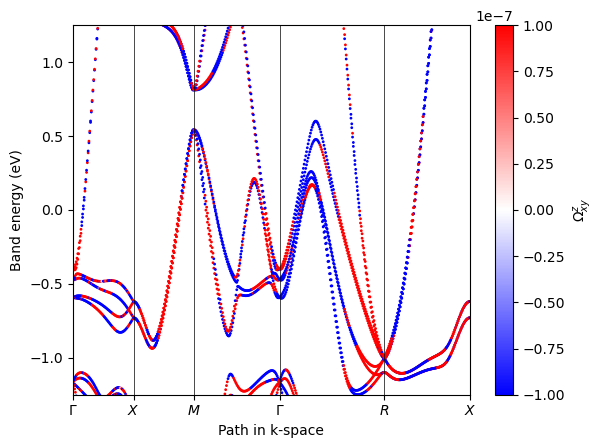

In [11]:
# Plotting
cmax = 1e-7
plt.set_cmap('bwr')
for i in range(energies.shape[0]):
    plt.scatter(k_dist,energies[i], s=1, c=Omega_xyz[i])
    plt.clim(-cmax, cmax)
plt.colorbar(label="$\\Omega^z_{xy}$")
for n in range(len(k_node)):
    plt.axvline(x=k_node[n],linewidth=0.5, color='k')
plt.xlabel("Path in k-space")
plt.ylabel("Band energy (eV)")
plt.xlim(k_dist[0],k_dist[-1])
plt.ylim(-1.25, 1.25)
plt.xticks(k_node, labels=k_label)
plt.show()